# Twirling of effective noise channel

In [1]:
from pyquil.quil import *
from pyquil.api import get_qc
from pyquil.gates import *
from pyquil.latex import display, to_latex
from pyquil.simulation.tools import lifted_gate, program_unitary, lifted_gate_matrix
import forest.benchmarking.distance_measures as dm

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas() #This line make sure that the progress bars looks natural

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from functions import *

In [42]:
qc = get_qc('2q-qvm')

## Generation of Haar random circuits

In [24]:
target_qubits = 0
# prog = give_random_two_qubit_circuit(target_qubits)
prog = give_random_single_qubit_gate(target_qubits)
# prog.instructions

### Find the (4,4)-matrix representation of each gate

In [25]:
matrix_list = []
for gate in prog.instructions:
    matrix_list.append( program_unitary( Program(gate), n_qubits = 1) )
# matrix_list

### Amplitude damping noise

In [113]:
# gamma = 0.01
# amp_damp_kraus = [ np.array([[1,0],[0,np.sqrt(1 - gamma)]]), np.array([ [0, np.sqrt(gamma)], [0,0] ]) ]

In [114]:
gates_num = len(matrix_list)
kraus_set = []
for k in amp_damp_kraus:
    for i in np.arange(gates_num-1,-1,-1):
        new_k = np.copy(k) #needs to be here
        for j in np.arange(i,-1,-1):
            new_k = matrix_list[j].T.conj() @ new_k @ matrix_list[j]
        kraus_set.append(new_k)

In [116]:
kraus_space = []
for k in kraus_set:
    for l in kraus_set:
        kraus_space.append( k@l )

In [117]:
len(kraus_space)

100

## Two-qubits noise channel
This should be the series of depolarizing and amplitude damping for each product space

In [118]:
oo_state = np.zeros((4,4), dtype = np.complex128)
oo_state[0,0] = 1

In [188]:
def ad_chan_single_qubit(input_state_density_mat, qubit_index, gamma = 0.01):
    amp_damp_kraus = [ np.array([[1,0],[0,np.sqrt(1 - gamma)]]), np.array([ [0, np.sqrt(gamma)], [0,0] ]) ]
    if qubit_index == 0:
        kraus_set = [ np.kron(k, np.eye(2, dtype = np.complex128)) for k in amp_damp_kraus]
    elif qubit_index == 1:
        kraus_set = [ np.kron(np.eye(2, dtype = np.complex128), k) for k in amp_damp_kraus]
    output_state_density_mat = np.zeros((4,4), dtype = np.complex128)
    for k in kraus_set:
        output_state_density_mat += k @ input_state_density_mat @ k.T.conj()
    return output_state_density_mat

In [33]:
ad_chan_single_qubit(oo_state, qubit_index=0)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [189]:
epsilon = 0.5
pauli_ops = [np.eye(2),
             np.array([ [0, 1], [1, 0] ]),
            np.array([ [0, -1j], [1j, 0] ]),
            np.array([ [1, 0], [0, -1] ])]
depolarizing_channel_kraus = np.array( [ np.sqrt(1 - 3*epsilon/4)*pauli_ops[0],
                                        np.sqrt(epsilon/4)*pauli_ops[1],
                                        np.sqrt(epsilon/4)*pauli_ops[2],
                                        np.sqrt(epsilon/4)*pauli_ops[3]], dtype = np.complex128)


def depol_chan_single_qubit(input_state_density_mat, qubit_index, epsilon = 0.01):
    depolarizing_channel_kraus = np.array( [ np.sqrt(1 - 3*epsilon/4)*pauli_ops[0],
                                        np.sqrt(epsilon/4)*pauli_ops[1],
                                        np.sqrt(epsilon/4)*pauli_ops[2],
                                        np.sqrt(epsilon/4)*pauli_ops[3]], dtype = np.complex128)
    if qubit_index == 0:
        kraus_set = [ np.kron(k, np.eye(2)) for k in depolarizing_channel_kraus]
    elif qubit_index == 1:
        kraus_set = [ np.kron(np.eye(2), k) for k in depolarizing_channel_kraus]
    output_state_density_mat = np.zeros((4,4), dtype = np.complex128)
    for k in kraus_set:
        output_state_density_mat += k @ input_state_density_mat @ k.T.conj()
    return output_state_density_mat

In [177]:
depol_chan_single_qubit(oo_state, qubit_index=0)

array([[0.75+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j]])

In [193]:
def ad_depol_chan_two_qubits(input_state_density_mat, ad_channel_coeff, depol_channel_coeff):
    working_state = np.copy(input_state_density_mat)
    
    working_state = ad_chan_single_qubit(working_state, qubit_index=0, gamma=ad_channel_coeff)
    working_state = ad_chan_single_qubit(working_state, qubit_index=1, gamma=ad_channel_coeff)
    
    working_state = depol_chan_single_qubit(working_state, qubit_index=0, epsilon=depol_channel_coeff)
    working_state = depol_chan_single_qubit(working_state, qubit_index=1, epsilon=depol_channel_coeff)
    output_state = np.copy(working_state)
    return output_state

In [191]:
# def convex_ad_depol_chan_two_qubits(input_state_density_mat):
#     p = 0.1
#     working_state = np.copy(input_state_density_mat)
    
#     working_state = ad_chan_single_qubit(working_state, qubit_index=0)
#     working_state = ad_chan_single_qubit(working_state, qubit_index=1)
    
#     working_state = depol_chan_single_qubit(working_state, qubit_index=0)
#     working_state = depol_chan_single_qubit(working_state, qubit_index=1)
#     output_state = np.copy(working_state)
#     return output_state

In [192]:
def simple_rotation_chan_two_qubits(input_state_density_mat, rotation_mat):
    output_state_density_mat = rotation_mat @ input_state_density_mat @ rotation_mat.T.conj()
    return output_state_density_mat

## Make a noisy Haar circuit

In [196]:
target_qubits = [0, 1]
input_state_mat = np.eye(4, dtype = np.complex128) / 4

def random_haar_circuit_two_qubits(target_qubits):
    prog = give_random_two_qubit_circuit(target_qubits)
    prog_inst = prog.instructions
    return prog_inst

def break_circuit_into_parts(prog_inst):
    cz_indices = []
    for i, gate in enumerate(prog_inst):
        if gate.name == 'CZ': cz_indices.append(i)

    inst_part_one = prog_inst[:cz_indices[0]+1]
    inst_part_two = prog_inst[cz_indices[0]+1:cz_indices[1]+1]
    inst_part_three = prog_inst[cz_indices[1]+1:cz_indices[2]+1]
    inst_part_four = prog_inst[cz_indices[2]+1:]

    inst_parts = [inst_part_one, inst_part_two, inst_part_three, inst_part_four]
    return inst_parts

def eff_noise_chan_two_qubits(two_qubit_circuit_instructions, ad_channel_coeff = 0.1, depol_channel_coeff = 0.1):
    
    inst_parts = break_circuit_into_parts(two_qubit_circuit_instructions)
    
    def channel(input_state_mat):
        output_state_mat = np.copy(input_state_mat)
        #noisy circuit
        for part in inst_parts[:-1]:
            part_mat = program_unitary(Program(part), n_qubits=2)
            output_state_mat = simple_rotation_chan_two_qubits(output_state_mat, part_mat)
            
            output_state_mat = ad_depol_chan_two_qubits(output_state_mat, ad_channel_coeff, depol_channel_coeff )
                
        part_mat = program_unitary(Program(inst_parts[-1]), n_qubits=2)
        output_state_mat = simple_rotation_chan_two_qubits(output_state_mat, part_mat)

        #noiseless inverse
        inverse_circuit_mat = program_unitary( Program( list(get_inverse_circuit(qc, two_qubit_circuit_instructions)) ), n_qubits = 2)
        output_state_mat = simple_rotation_chan_two_qubits(output_state_mat, inverse_circuit_mat)
        return output_state_mat
    return channel


In [182]:
# eff_noise_chan_two_qubits(input_state_mat)

In [195]:
def chan2choi_mat_two_qubits(channel):
    choi_mat = np.zeros((16,16), dtype = np.complex128)
    for i in range(4):
        for j in range(4):
            eij = np.zeros((4,4), dtype = np.complex128)
            eij[i,j] = 1
            choi_mat = choi_mat + np.kron(eij, channel(eij))
    return choi_mat

In [184]:
haar_circuit_one = random_haar_circuit_two_qubits([0,1])
haar_circuit_two = random_haar_circuit_two_qubits([0,1])

eff_channel_func_one = eff_noise_chan_two_qubits(haar_circuit_one)
eff_channel_func_two = eff_noise_chan_two_qubits(haar_circuit_two)

In [185]:
choi_one = chan2choi_mat_two_qubits(eff_channel_func_one)
choi_two = chan2choi_mat_two_qubits(eff_channel_func_two)

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])


In [186]:
dnorm = dm.diamond_norm_distance(choi_one, choi_two)

C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 32 times so far.

  warnings.warn(msg, UserWarning)


In [187]:
dnorm

0.11145780556064545

## Gate-dependence esitmation

In [6]:
import pandas as pd
from csv import writer

In [222]:
path = os.getcwd()
file_path = os.path.join(path, 'effective_noise.csv')
if os.path.isfile(file_path):
    pass
else:
    with open(file_path, 'w') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(['amplitude damping coeff', 'depolarising coeff', 'diamond dist mean', 'diamond dist error'])
        f_object.close()

In [218]:
def record_this_channel(gamma, epsilon, dnorm_average, dnorm_err):
    List = [gamma, epsilon, dnorm_average, dnorm_err]
    with open(file_path, 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(List)
        f_object.close()
    return

In [219]:
# dnorm_df = pd.DataFrame(columns=['amplitude damping coeff', 'depolarising coeff', 'diamond dist mean', 'diamond dist error'])

In [229]:
ad_coeff_range = np.arange(0.001, 0.011, 0.001)
# ad_coeff_range = np.array([0.001, 0.01, 0.1, 0.2])
# ad_coeff_range = np.array([0.0])
depol_coeff_range = np.arange(0.001, 0.011, 0.001)
# depol_coeff_range = np.arange(0.01, 0.2, 1)
# depol_coeff_range = np.array([0.1])
num_samples = 10

for gamma in tqdm(ad_coeff_range, desc = 'gamma'):
    for epsilon in tqdm(depol_coeff_range, desc = 'epsilon'):
        diamond_distance_samples = []
        for i in tqdm(range(num_samples)):
            haar_circuit_one = random_haar_circuit_two_qubits([0,1])
            haar_circuit_two = random_haar_circuit_two_qubits([0,1])

            eff_channel_func_one = eff_noise_chan_two_qubits(haar_circuit_one, ad_channel_coeff=gamma, depol_channel_coeff=epsilon)
            eff_channel_func_two = eff_noise_chan_two_qubits(haar_circuit_two, ad_channel_coeff=gamma, depol_channel_coeff=epsilon)

            choi_one = chan2choi_mat_two_qubits(eff_channel_func_one)
            choi_two = chan2choi_mat_two_qubits(eff_channel_func_two)

            dnorm = dm.diamond_norm_distance(choi_one, choi_two)
            diamond_distance_samples.append(dnorm)
        record_this_channel(gamma, epsilon, np.mean(diamond_distance_samples), np.std(diamond_distance_samples))
#         dnorm_df.append({'amplitude damping coeff':gamma, 
#                          'depolarising coeff':epsilon,
#                          'diamond dist mean':np.mean(diamond_distance_samples),
#                          'diamond dist error':np.std(diamond_distance_samples)}, ignore_index=True)

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for gamma in tqdm(ad_coeff_range, desc = 'gamma'):


gamma:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epsilon in tqdm(depol_coeff_range, desc = 'epsilon'):


epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2584 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2593 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2594 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2603 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2604 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2613 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2614 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2623 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2624 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2633 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2634 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2643 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2644 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2653 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2654 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2663 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2664 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2673 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2674 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2683 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2684 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2693 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2694 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2703 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2704 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2713 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2714 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2723 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2724 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2733 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2734 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2743 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2744 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2753 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2754 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2763 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2764 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2773 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2774 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2783 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2784 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2793 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2794 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2803 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2804 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2813 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2814 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2823 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2824 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2833 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2834 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2843 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2844 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2853 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2854 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2863 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2864 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2873 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2874 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2883 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2884 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2893 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2894 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2903 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2904 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2913 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2914 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2923 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2924 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2933 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2934 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2943 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2944 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2953 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2954 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2963 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2964 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2973 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2974 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2983 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2984 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2993 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2994 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3003 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3004 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3013 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3014 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3023 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3024 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3033 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3034 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3043 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3044 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3053 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3054 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3063 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3064 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3073 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3074 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3083 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3084 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3093 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3094 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3103 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3104 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3113 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3114 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3123 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3124 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3133 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3134 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3143 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3144 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3153 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3154 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3163 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3164 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3173 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3174 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3183 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3184 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3193 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3194 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3203 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3204 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3213 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3214 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3223 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3224 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3233 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3234 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3243 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3244 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3253 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3254 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3263 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3264 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3273 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3274 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3283 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3284 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3293 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3294 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3303 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3304 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3313 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3314 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3323 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3324 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3333 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3334 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3343 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3344 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3353 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3354 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3363 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3364 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3373 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3374 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3383 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3384 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3393 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3394 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3403 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3404 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3413 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3414 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3423 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3424 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3433 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3434 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3443 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3444 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3453 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3454 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3463 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3464 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3473 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3474 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3483 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(num_samples)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3484 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3493 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3494 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3503 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3504 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3513 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3514 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3523 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3524 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3533 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3534 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3543 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3544 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3553 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3554 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3563 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3564 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3573 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\AppData\Local\Temp\ipykernel_16880\860792251.py:1

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3574 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_B

C:\Users\mohsen\Documents\Python_pros\git_controlled\Randomized_Benchmarking_protocol\functions.py:687: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qubits = np.array([np.array(gate.qubits) for gate in gates_sequence])
C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3583 times so far.

  warnings.warn(msg, UserWarning)


,amplitude damping coeff,depolarising coeff,diamond dist mean,diamond dist error


In [7]:
dnorm_df = pd.read_csv('effective_noise.csv')

In [8]:
dnorm_df

,amplitude damping coeff,depolarising coeff,diamond dist mean,diamond dist error
0,0.001,0.001,0.010225,0.001559
1,0.001,0.010,0.034311,0.002092
2,0.001,0.100,0.209745,0.018173
3,0.001,0.200,0.259316,0.014611
4,0.010,0.001,0.100437,0.023736
...,...,...,...,...
112,0.010,0.006,0.088553,0.015280
113,0.010,0.007,0.097456,0.018406
114,0.010,0.008,0.093711,0.010228
115,0.010,0.009,0.099191,0.019766


### Contour plots

In [39]:
import seaborn as sns
from scipy.ndimage import median_filter
from scipy.interpolate import griddata

In [40]:
ad_coeff_min = dnorm_df['amplitude damping coeff'].min()
ad_coeff_max = dnorm_df['amplitude damping coeff'].max()

depol_coeff_min = dnorm_df['depolarising coeff'].min()
depol_coeff_max = dnorm_df['depolarising coeff'].max()

C:\Users\mohsen\AppData\Local\Temp\ipykernel_15508\1440141875.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


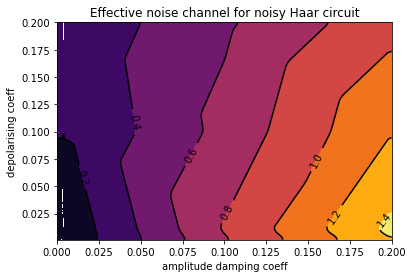

In [47]:
fig = plt.figure()
ax = fig.add_subplot()

grid_x, grid_y = np.mgrid[ad_coeff_min:ad_coeff_max:500j, depol_coeff_min:depol_coeff_max:500j]

points = dnorm_df[['amplitude damping coeff', 'depolarising coeff']]
values = dnorm_df['diamond dist mean']
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

extent = [ad_coeff_min,ad_coeff_max,depol_coeff_min,depol_coeff_max]    

filtered_grid = median_filter(grid_z.T, size = 20)

ax.contourf(filtered_grid, extent = extent, cmap = 'inferno')
C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)
ax.clabel(C, inline=1, fontsize=10)


ax.set_title('Effective noise channel for noisy Haar circuit')
ax.set_ylabel('depolarising coeff')
ax.set_xlabel('amplitude damping coeff')
# plt.close()
fig.savefig('ddistance vs noises coeffs phase space.png')

In [42]:
points

,0,1,2,3,4,5,6,7,8,9,...,105,106,108,109,110,111,112,113,114,115
depolarising coeff,0.001,0.010,0.100,0.200,0.001,0.01,0.10,0.20,0.001,0.01,...,0.009,0.010,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009
amplitude damping coeff,0.001,0.001,0.001,0.001,0.010,0.01,0.01,0.01,0.100,0.10,...,0.009,0.009,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0.010


In [43]:
values

0      0.010225
1      0.034311
2      0.209745
3      0.259316
4      0.100437
         ...   
111    0.084322
112    0.088553
113    0.097456
114    0.093711
115    0.099191
Name: diamond dist mean, Length: 113, dtype: float64

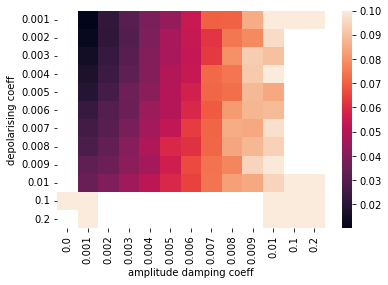

In [29]:
# dnorm_df = pd.read_clipboard()
fig = plt.figure()
ax = fig.add_subplot()

dnorm_df.drop_duplicates(['depolarising coeff','amplitude damping coeff'], inplace=True)
pivot = dnorm_df.pivot(index='depolarising coeff',
                       columns='amplitude damping coeff',
                       values='diamond dist mean')
ax = sns.heatmap(pivot,annot=False, vmax = 0.1)

fig.savefig('ddistance vs noises.png')

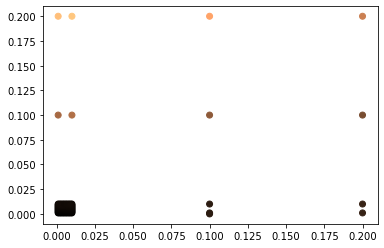

In [23]:
plt.scatter(dnorm_df['depolarising coeff'], dnorm_df['amplitude damping coeff'],
           c=dnorm_df['diamond dist mean'],  cmap="copper")